# Predicting <font color='blue'>Electric</font> Vehicle Rotor <font color='red'>*Temperature °C*</font>

## 1. Libraries and settings

**1.1 Importing libraries**

In [2]:
from winsound import Beep
import pandas as pd
# import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from time import time
import os
from sklearn.model_selection import train_test_split, GridSearchCV,\
    RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor,\
    RandomForestRegressor, BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.svm import SVR
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.callbacks import EarlyStopping
os.chdir('C:/Users/Nicolas/Documents/scraping/electric-motor-'\
         'temperature')

**1.2 Plot theme**

In [3]:
theme_color = '#B5DDA4'

def set_theme():
    return ax.set_facecolor(theme_color),\
    ax.grid(True, alpha=4e-1, color='white'),\
    ax.set_axisbelow(True)

**1.3 Run finished alert**

In [4]:
def alert():
    return Beep(1_200, 5_00)

## 2. Importing the data

**2.1 Importing**

In [5]:
df = pd.read_csv('pmsm_temperature_data.csv').astype(np.float32)

**2.2 Exploring**

2.2.1 Head

In [6]:
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4.0
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4.0
2,-0.782892,-1.116681,0.332772,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017344,4.0
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4.0
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4.0


2.2.2 Variable descriptions

- `ambient` Ambient temperature as measured by a thermal sensor located closely to the stator. <br>
- `coolant` Coolant temperature. The motor is water cooled. Measurement is taken at outflow.<br>
- `u_d` Voltage d-component<br>
- `u_q` Voltage q-component<br>
- `motor_speed` Motor speed<br>
- `torque` Torque induced by current.<br>
- `i_d` Current d-component<br>
- `i_q` Current q-component<br>
- `pm` Permanent Magnet surface temperature representing the rotor temperature. <br>
- `stator_yoke` Stator yoke temperature measured with a thermal sensor.<br>
- `stator_tooth` Stator tooth temperature measured with a thermal sensor.<br>
- `stator_winding` Stator winding temperature measured with a thermal sensor.<br>
- `profile_id` Each measurement session has a unique ID. <br>

2.2.3 Missing values

In [7]:
df.isnull().sum().sum()

0

2.2.4 Shape

In [8]:
df.shape

(998070, 13)

In [9]:
print(f'We have {df.shape[0]:,} rows and {df.shape[1]} columns.')

We have 998,070 rows and 13 columns.


2.2.5 Profile ID

In [10]:
df['profile_id'].value_counts().head()

20.0    43970
6.0     40387
65.0    40093
66.0    36475
27.0    35360
Name: profile_id, dtype: int64

In [11]:
df = df.loc[df['profile_id'] == 20].drop('profile_id', axis=1)

In [12]:
print(f'We now have {df.shape[0]:,} rows and {df.shape[1]} columns.')

We now have 43,970 rows and 12 columns.


2.2.6 Correlation Matrix

In [13]:
df = df.rename(columns={'stator_yoke':'yoke', 'stator_tooth':'tooth', 'stator_winding':'winding'})

In [14]:
(np.round(df.corr().iloc[:-1, :], 6).style.format({})
 .background_gradient(cmap='RdYlGn', low=.4, high=.4)
)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,yoke,tooth,winding
ambient,1,0.732546,-0.116566,-0.166344,0.040813,-0.028495,-0.101042,-0.032948,0.574095,0.759837,0.63667,0.509429
coolant,0.732546,1,-0.001174,-0.066948,-0.110457,-0.063609,0.12658,-0.034647,0.237368,0.811872,0.560639,0.375406
u_d,-0.116566,-0.001174,1,0.036672,-0.662405,-0.596901,0.89119,-0.532353,-0.580232,-0.414595,-0.623072,-0.723109
u_q,-0.166344,-0.066948,0.036672,1,0.458356,-0.179879,0.059739,-0.15156,-0.204726,-0.100949,-0.11124,-0.161283
motor_speed,0.040813,-0.110457,-0.662405,0.458356,1,-0.001776,-0.786186,-0.070917,0.444886,0.247069,0.45647,0.521446
torque,-0.028495,-0.063609,-0.596901,-0.179879,-0.001776,1,-0.439186,0.992171,0.26557,0.185622,0.307752,0.416969
i_d,-0.101042,0.12658,0.89119,0.059739,-0.786186,-0.439186,1,-0.342511,-0.615226,-0.343533,-0.604713,-0.735469
i_q,-0.032948,-0.034647,-0.532353,-0.15156,-0.070917,0.992171,-0.342511,1,0.219197,0.169929,0.264509,0.358426
pm,0.574095,0.237368,-0.580232,-0.204726,0.444886,0.26557,-0.615226,0.219197,1,0.69267,0.840942,0.855445
yoke,0.759837,0.811872,-0.414595,-0.100949,0.247069,0.185622,-0.343533,0.169929,0.69267,1,0.935035,0.832941


## 3. Visualizing distributions of the target variables

**3.1 Stator yoke**

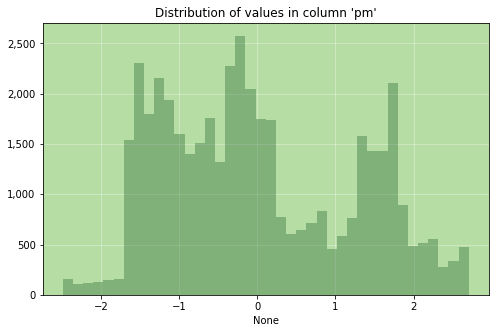

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
set_theme()
sns.distplot(df.iloc[:, -4], color='#327038', 
             bins=40, kde=False)
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
plt.title("Distribution of values in column '{}'".format(df.columns[-4]))
plt.xlabel(None)
plt.show()

**3.2 Stator tooth**

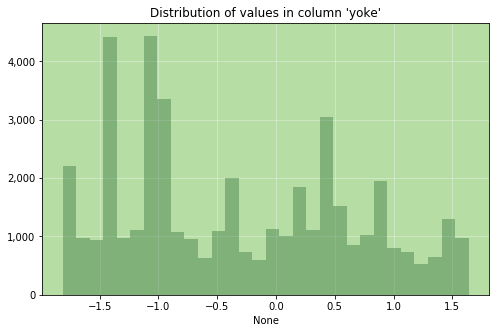

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
set_theme()
sns.distplot(df.iloc[:, -3], color='#327038', 
             bins=30, kde=False)
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
plt.title("Distribution of values in column '{}'".format(df.columns[-3]))
plt.xlabel(None)
plt.show()

**3.3 Stator winding**

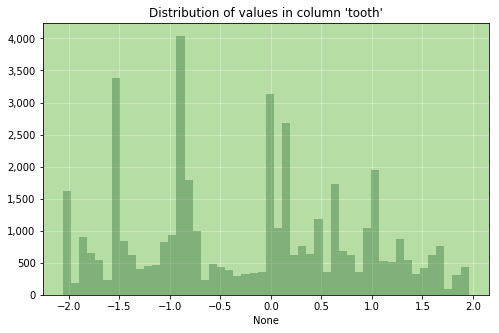

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
set_theme()
sns.distplot(df.iloc[:, -2], color='#327038', 
             bins=50, kde=False)
ax.set_yticklabels(['{:,}'.format(x) for x in np.array(ax.get_yticks(), 
                                                       dtype=int)])
plt.title("Distribution of values in column '{}'".format(df.columns[-2]))
plt.xlabel(None)
plt.show()

## 4. Processing data for predictive modeling

**4.1 Separating the predictor and target variables**

In [18]:
X = df.drop(['yoke', 'tooth', 'winding'], axis=1).values

In [19]:
y_yoke = df['yoke'].values
y_tooth = df['tooth'].values
y_winding = df['winding'].values

**4.2 Train/test split**

In [20]:
X_train, X_test, yoke_train, yoke_test, tooth_train, tooth_test,\
            winding_train, winding_test = train_test_split(X, y_yoke, 
            y_tooth, y_winding, test_size=2e-1)

## 5. Predictive modeling

### 5.1 Linear Regression

5.1.1 Instantiating the model

In [21]:
reg_yoke = LinearRegression(n_jobs=-1)
reg_tooth = LinearRegression(n_jobs=-1)
reg_winding = LinearRegression(n_jobs=-1)

5.1.2 Fitting the model

In [22]:
reg_yoke.fit(X_train, yoke_train)
reg_tooth.fit(X_train, tooth_train)
reg_winding.fit(X_train, winding_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

5.1.3 Making predictions

In [23]:
reg_yoke_pred = reg_yoke.predict(X_test)
reg_tooth_pred = reg_tooth.predict(X_test)
reg_winding_pred = reg_winding.predict(X_test)

5.1.4 Evaluating predictions

In [24]:
mae_reg_yoke = mean_absolute_error(yoke_test, reg_yoke_pred)
mae_reg_tooth = mean_absolute_error(tooth_test, reg_tooth_pred)
mae_reg_winding = mean_absolute_error(winding_test, reg_winding_pred)
mae_reg_yoke, mae_reg_tooth, mae_reg_winding

(0.1305153, 0.17445399, 0.1941152)

5.1.5 Interpreting coefficients

In [25]:
pd.DataFrame([reg_yoke.coef_, reg_tooth.coef_, reg_winding.coef_], 
             index=['Yoke', 'Tooth', 'Winding'], columns=df.drop(['yoke', 'tooth', 'winding'], 
             axis=1).columns.values)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm
Yoke,-0.141422,0.854417,-0.049346,0.008969,0.220990,3.632026,0.340488,-3.224398,0.416592
Tooth,-0.212942,0.689089,-0.020080,-0.123356,0.595140,5.656495,0.631485,-4.897159,0.574417
Winding,-0.251175,0.572213,0.087256,-0.313239,0.945791,7.392169,0.862015,-6.207423,0.585768


5.1.6 Making a metrics dataframe

In [26]:
metrics = pd.DataFrame([mae_reg_yoke, mae_reg_tooth, mae_reg_winding], 
                       columns=['Lin. Reg.'], 
                       index=['MAE Yoke', 'MAE Tooth', 'MAE Winding']).T
metrics

,MAE Yoke,MAE Tooth,MAE Winding
Lin. Reg.,0.130515,0.174454,0.194115


5.1.7 Plotting the metrics

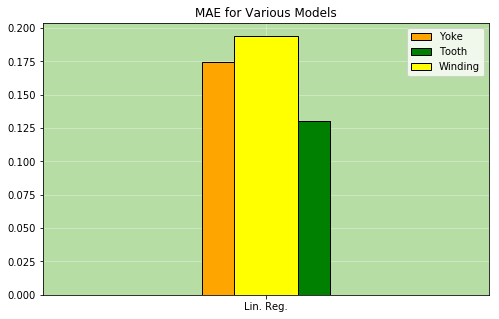

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))
set_theme()

ax.bar(metrics.index, metrics.iloc[:, 1].values, color='orange', 
       edgecolor='k', linewidth=1, width=-1, align='edge', 
       alpha=1)

ax.bar(metrics.index, metrics.iloc[:, 0].values, color='green', 
       edgecolor='k', linewidth=1, width=1, align='edge', 
       alpha=1)

ax.bar(metrics.index, metrics.iloc[:, 2].values, color='yellow', 
       edgecolor='k', linewidth=1, width=1, alpha=1)

plt.xlim(-3.5, 3.5)
plt.legend(['Yoke', 'Tooth', 'Winding'])
plt.title('MAE for Various Models')
plt.show()

### 5.2 Decision Tree Regressor

5.1.1 Instantiating the model

In [28]:
tree_yoke = DecisionTreeRegressor()
tree_tooth = DecisionTreeRegressor()
tree_winding = DecisionTreeRegressor()

5.1.2 Fitting a basic model

In [29]:
tree_yoke.fit(X_train, yoke_train)
tree_tooth.fit(X_train, tooth_train)
tree_winding.fit(X_train, winding_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

5.1.3 Making predictions

In [30]:
tree_yoke_pred = tree_yoke.predict(X_test)
tree_tooth_pred = tree_tooth.predict(X_test)
tree_winding_pred = tree_winding.predict(X_test)

5.1.4 Evaluating predictions

In [31]:
mae_tree_yoke = mean_absolute_error(yoke_test, tree_yoke_pred)
mae_tree_tooth = mean_absolute_error(tooth_test, tree_tooth_pred)
mae_tree_winding = mean_absolute_error(winding_test, tree_winding_pred)
mae_tree_yoke, mae_tree_tooth, mae_tree_winding

(0.0016755280492423196, 0.002238414532350303, 0.0029399182598904682)

5.1.5. Grid search

In [32]:
yoke_grid = RandomizedSearchCV(tree_yoke, cv=3,
            param_distributions=
                        {'min_samples_split': np.linspace(2, 100, 25, dtype=int),
                        'max_depth': [None, 5, 10, 20, 50, 100, 200],
                        'max_features': [8, 9, None]},
                  n_jobs=-1, n_iter=15)
tooth_grid = RandomizedSearchCV(tree_tooth, cv=5,
            param_distributions=
                        {'min_samples_split': np.linspace(2, 100, 25, dtype=int),
                         'max_depth': [None, 5, 10, 20, 50, 100, 200],
                         'max_features': [8, 9, None]},
                  n_jobs=-1, n_iter=15)
winding_grid = RandomizedSearchCV(tree_winding, cv=5,
            param_distributions=
                        {'min_samples_split': np.linspace(2, 100, 25, dtype=int),
                         'max_depth': [None, 5, 10, 20, 50, 100, 200],
                         'max_features': [8, 9, None]},
                  n_jobs=-1, n_iter=15)

In [33]:
start_timer = time()
yoke_grid.fit(X_train, yoke_train)
tooth_grid.fit(X_train, tooth_train)
winding_grid.fit(X_train, winding_train)
stop_timer = time()
print(str(round(stop_timer-start_timer)), 'seconds')

23 seconds


In [34]:
tree_yoke_pred_cv = yoke_grid.best_estimator_.predict(X_test)
tree_tooth_pred_cv = tooth_grid.best_estimator_.predict(X_test)
tree_winding_pred_cv = winding_grid.best_estimator_.predict(X_test)

In [35]:
tree_yoke_pred_cv_mae = mean_absolute_error(yoke_test, tree_yoke_pred_cv)
tree_tooth_pred_cv_mae = mean_absolute_error(tooth_test, tree_tooth_pred_cv)
tree_winding_pred_cv_mae = mean_absolute_error(winding_test, tree_winding_pred_cv)
tree_yoke_pred_cv_mae, tree_tooth_pred_cv_mae, tree_winding_pred_cv_mae

(0.0020781471406845233, 0.002591512738163349, 0.003896100359989437)

5.1.5 Interpreting coefficients

In [36]:
pd.DataFrame([tree_yoke.feature_importances_, tree_tooth.feature_importances_, 
              tree_winding.feature_importances_], index=['Yoke', 'Tooth', 'Winding'], 
              columns=df.drop(['yoke', 'tooth', 'winding'], 
             axis=1).columns.values)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm
Yoke,0.000409,0.669342,0.016652,0.007577,0.003491,0.006325,0.019702,0.006661,0.269841
Tooth,0.000270,0.011678,0.037183,0.019931,0.015219,0.087017,0.001411,0.095883,0.731410
Winding,0.017744,0.000438,0.125032,0.012457,0.007002,0.048073,0.054685,0.024685,0.709884


5.1.6 Making a metrics dataframe

In [37]:
metrics_tree = pd.DataFrame([mae_tree_yoke, mae_tree_tooth, 
                              mae_tree_winding], columns=['Decision Tree'], 
                       index=['MAE Yoke', 'MAE Tooth', 'MAE Winding']).T

metrics = pd.concat([metrics, metrics_tree], axis=0, sort=False)
metrics

,MAE Yoke,MAE Tooth,MAE Winding
Lin. Reg.,0.130515,0.174454,0.194115
Decision Tree,0.001676,0.002238,0.002940


5.1.7 Plotting the metrics

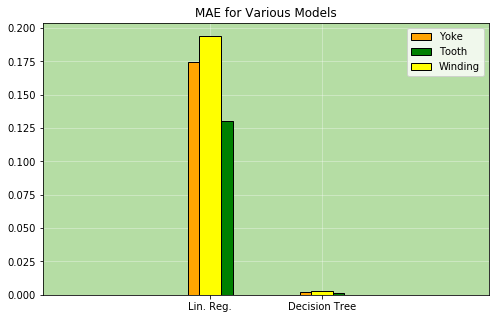

In [38]:
fig, ax = plt.subplots(figsize=(8, 5))
set_theme()

ax.bar(metrics.index, metrics.iloc[:, 1].values, color='orange', 
       edgecolor='k', linewidth=1, width=-0.2, align='edge', 
       alpha=1)

ax.bar(metrics.index, metrics.iloc[:, 0].values, color='green', 
       edgecolor='k', linewidth=1, width=0.2, align='edge', 
       alpha=1)

ax.bar(metrics.index, metrics.iloc[:, 2].values, color='yellow', 
       edgecolor='k', linewidth=1, width=.2, alpha=1)

plt.xlim(-1.5, 2.5)
plt.legend(['Yoke', 'Tooth', 'Winding'])
plt.title('MAE for Various Models')
plt.show()

### 5.3 Fully-Connected Neural Network 

5.3.1 Rescaling the data

In [39]:
mm_scaler = MinMaxScaler()

In [40]:
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

5.3.2 Building the models

In [82]:
nn_yoke = Sequential([
    Dense(64, input_shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(5e-1),
    Dense(1, activation='linear')
])

In [83]:
nn_tooth = Sequential([
    Dense(64, input_shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(5e-1),
    Dense(1, activation='linear')
])

In [84]:
nn_winding = Sequential([
    Dense(64, input_shape=(X_train_scaled.shape[1],)),
    Dense(126, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(5e-1),
    Dense(1, activation='linear')
])

5.3.3 Model parameters

In [85]:
batch_size=128
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
epochs=50

5.3.4 Compiling the models

In [86]:
nn_yoke.compile(optimizer='adam', loss='mae')
nn_tooth.compile(optimizer='adam', loss='mae')
nn_winding.compile(optimizer='adam', loss='mae')

5.3.5 Training the models

In [87]:
yoke_history = nn_yoke.fit(X_train_scaled, yoke_train,
               verbose=1,
               callbacks=[early_stopping],
               epochs=epochs,
               batch_size=batch_size,
               validation_data=[X_test_scaled, yoke_test])

Train on 35176 samples, validate on 8794 samples
Epoch 1/50
35176/35176 [==============================] - 3s 71us/step - loss: 0.1843 - val_loss: 0.0935
Epoch 2/50
35176/35176 [==============================] - 1s 37us/step - loss: 0.1243 - val_loss: 0.0858
Epoch 3/50
35176/35176 [==============================] - 1s 37us/step - loss: 0.1162 - val_loss: 0.0806
Epoch 4/50
35176/35176 [==============================] - 1s 37us/step - loss: 0.1107 - val_loss: 0.0602
Epoch 5/50
35176/35176 [==============================] - 2s 43us/step - loss: 0.1077 - val_loss: 0.0628
Epoch 6/50
35176/35176 [==============================] - 1s 42us/step - loss: 0.1055 - val_loss: 0.0609
Epoch 7/50
35176/35176 [==============================] - 2s 46us/step - loss: 0.1031 - val_loss: 0.0526
Epoch 8/50
35176/35176 [==============================] - 1s 42us/step - loss: 0.1027 - val_loss: 0.0463
Epoch 9/50
35176/35176 [==============================] - 1s 42us/step - loss: 0.1006 - val_loss: 0.0548
Epoch 

In [90]:
tooth_history = nn_tooth.fit(X_train_scaled, tooth_train,
                verbose=1,
                callbacks=[early_stopping],
                epochs=epochs,
                batch_size=batch_size,
                validation_data=[X_test_scaled, tooth_test])

Train on 35176 samples, validate on 8794 samples
Epoch 1/50
35176/35176 [==============================] - 1s 38us/step - loss: 0.1071 - val_loss: 0.0687
Epoch 2/50
35176/35176 [==============================] - 2s 43us/step - loss: 0.1060 - val_loss: 0.0609
Epoch 3/50
35176/35176 [==============================] - 1s 41us/step - loss: 0.1033 - val_loss: 0.0388
Epoch 4/50
35176/35176 [==============================] - 1s 38us/step - loss: 0.1015 - val_loss: 0.0542
Epoch 5/50
35176/35176 [==============================] - 1s 38us/step - loss: 0.1016 - val_loss: 0.0464
Epoch 6/50
35176/35176 [==============================] - 1s 38us/step - loss: 0.1005 - val_loss: 0.0459
Epoch 7/50
35176/35176 [==============================] - 1s 40us/step - loss: 0.1018 - val_loss: 0.0612
Epoch 8/50
35176/35176 [==============================] - 1s 40us/step - loss: 0.1000 - val_loss: 0.0710
Epoch 9/50
35176/35176 [==============================] - 1s 42us/step - loss: 0.0996 - val_loss: 0.0680
Epoch 

In [91]:
winding_history = nn_winding.fit(X_train_scaled, winding_train,
                  verbose=1,
                  callbacks=[early_stopping],
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_data=[X_test_scaled, winding_test])

Train on 35176 samples, validate on 8794 samples
Epoch 1/50
35176/35176 [==============================] - 1s 39us/step - loss: 0.1687 - val_loss: 0.0892
Epoch 2/50
35176/35176 [==============================] - 1s 40us/step - loss: 0.1614 - val_loss: 0.0865
Epoch 3/50
35176/35176 [==============================] - 1s 37us/step - loss: 0.1564 - val_loss: 0.0755
Epoch 4/50
35176/35176 [==============================] - 1s 38us/step - loss: 0.1530 - val_loss: 0.0927
Epoch 5/50
35176/35176 [==============================] - 1s 38us/step - loss: 0.1525 - val_loss: 0.0795
Epoch 6/50
35176/35176 [==============================] - 1s 38us/step - loss: 0.1495 - val_loss: 0.0748
Epoch 7/50
35176/35176 [==============================] - 1s 39us/step - loss: 0.1488 - val_loss: 0.0692
Epoch 8/50
35176/35176 [==============================] - 1s 41us/step - loss: 0.1447 - val_loss: 0.0657
Epoch 9/50
35176/35176 [==============================] - 1s 39us/step - loss: 0.1445 - val_loss: 0.0673
Epoch 

5.3.6 Making predictions

In [92]:
nn_yoke_pred = nn_yoke.predict(X_test_scaled)
nn_tooth_pred = nn_tooth.predict(X_test_scaled)
nn_winding_pred = nn_winding.predict(X_test_scaled)

5.1.4 Evaluating predictions

In [93]:
mae_nn_yoke = mean_absolute_error(yoke_test, nn_yoke_pred)
mae_nn_tooth = mean_absolute_error(tooth_test, nn_tooth_pred)
mae_nn_winding = mean_absolute_error(winding_test, nn_winding_pred)
mae_nn_yoke, mae_nn_tooth, mae_nn_winding

(0.024188332, 0.038796525, 0.046080757)

5.1.6 Making a metrics dataframe

In [94]:
metrics_nn = pd.DataFrame([mae_nn_yoke, mae_nn_tooth, 
                              mae_nn_winding], columns=['Neural Net'], 
                       index=['MAE Yoke', 'MAE Tooth', 'MAE Winding']).T

metrics = pd.concat([metrics, metrics_nn], axis=0, sort=False)
metrics

,MAE Yoke,MAE Tooth,MAE Winding
Lin. Reg.,0.130515,0.174454,0.194115
Decision Tree,0.001676,0.002238,0.002940
Neural Net,0.024188,0.038797,0.046081


5.1.7 Plotting the metrics

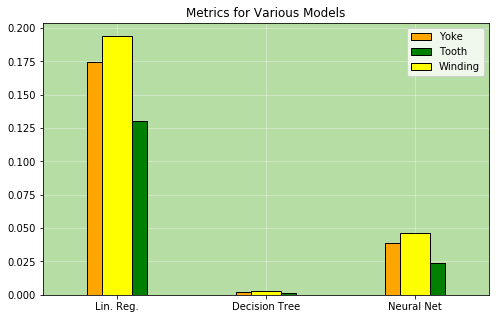

In [99]:
fig, ax = plt.subplots(figsize=(8, 5))
set_theme()

ax.bar(metrics.index, metrics.iloc[:, 1].values, color='orange', 
       edgecolor='k', linewidth=1, width=-0.2, align='edge', 
       alpha=1)

ax.bar(metrics.index, metrics.iloc[:, 0].values, color='green', 
       edgecolor='k', linewidth=1, width=0.2, align='edge', 
       alpha=1)

ax.bar(metrics.index, metrics.iloc[:, 2].values, color='yellow', 
       edgecolor='k', linewidth=1, width=.2, alpha=1)

plt.xlim(-.5, 2.5)
plt.legend(['Yoke', 'Tooth', 'Winding'])
plt.title('Metrics for Various Models')
plt.show()

### 5.4 AdaBoost Regressor

5.4.1 Instantiating the model

In [100]:
adb_yoke = AdaBoostRegressor()
adb_tooth = AdaBoostRegressor()
adb_winding = AdaBoostRegressor()

5.4.2 Fitting a basic model

In [101]:
start_timer = time()
adb_yoke.fit(X_train, yoke_train)
adb_tooth.fit(X_train, tooth_train)
adb_winding.fit(X_train, winding_train)
stop_timer = time()
print(str(int(stop_timer-start_timer)), 'seconds')

12 seconds


5.4.3 Making predictions

In [102]:
adb_yoke_pred = adb_yoke.predict(X_test)
adb_tooth_pred = adb_tooth.predict(X_test)
adb_winding_pred = adb_winding.predict(X_test)

5.4.4 Evaluating predictions

In [103]:
mae_adb_yoke = mean_absolute_error(yoke_test, adb_yoke_pred)
mae_adb_tooth = mean_absolute_error(tooth_test, adb_tooth_pred)
mae_adb_winding = mean_absolute_error(winding_test, adb_winding_pred)
mae_adb_yoke, mae_adb_tooth, mae_adb_winding

(0.18874579970533323, 0.24222200862440438, 0.26588630385561823)

5.4.5 Grid search

In [104]:
yoke_grid = RandomizedSearchCV(adb_yoke, cv=3,
            param_distributions=
                        {'n_estimators': np.linspace(3, 50, 25, dtype=int),
                         'learning_rate': np.linspace(1, 10, 20, dtype=int)},
                         n_jobs=-1, n_iter=50)
tooth_grid = RandomizedSearchCV(adb_tooth, cv=5,
            param_distributions=
                        {'n_estimators': np.linspace(3, 50, 25, dtype=int),
                         'learning_rate': np.linspace(1, 10, 20, dtype=int)},
                         n_jobs=-1, n_iter=50)
winding_grid = RandomizedSearchCV(adb_winding, cv=5,
            param_distributions=
                        {'n_estimators': np.linspace(3, 50, 25, dtype=int),
                         'learning_rate': np.linspace(1, 10, 20, dtype=int)},
                         n_jobs=-1, n_iter=50)

In [105]:
start_timer = time()
yoke_grid.fit(X_train, yoke_train)
tooth_grid.fit(X_train, tooth_train)
winding_grid.fit(X_train, winding_train)
stop_timer = time()
print(str(int((stop_timer-start_timer)/60)), 'minutes')
alert()

4 minutes


In [106]:
ada_yoke_pred_cv = yoke_grid.best_estimator_.predict(X_test)
ada_tooth_pred_cv = tooth_grid.best_estimator_.predict(X_test)
ada_winding_pred_cv = winding_grid.best_estimator_.predict(X_test)

In [107]:
ada_yoke_pred_cv_mae = mean_absolute_error(yoke_test, ada_yoke_pred_cv)
ada_tooth_pred_cv_mae = mean_absolute_error(tooth_test, ada_tooth_pred_cv)
ada_winding_pred_cv_mae = mean_absolute_error(winding_test, ada_winding_pred_cv)
ada_yoke_pred_cv_mae, ada_tooth_pred_cv_mae, ada_winding_pred_cv_mae

(0.17456673790353558, 0.210692645279599, 0.23982166735577723)

5.4.6 Interpreting coefficients

In [108]:
pd.DataFrame([tree_yoke.feature_importances_, tree_tooth.feature_importances_, 
              tree_winding.feature_importances_], index=['Yoke', 'Tooth', 'Winding'], 
              columns=df.drop(['yoke', 'tooth', 'winding'], 
             axis=1).columns.values)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm
Yoke,0.000409,0.669342,0.016652,0.007577,0.003491,0.006325,0.019702,0.006661,0.269841
Tooth,0.000270,0.011678,0.037183,0.019931,0.015219,0.087017,0.001411,0.095883,0.731410
Winding,0.017744,0.000438,0.125032,0.012457,0.007002,0.048073,0.054685,0.024685,0.709884


5.4.7 Making a metrics dataframe

In [109]:
metrics_ada = pd.DataFrame([ada_yoke_pred_cv_mae, ada_tooth_pred_cv_mae, 
                            ada_winding_pred_cv_mae], columns=['AdaBoost'], 
                            index=['MAE Yoke', 'MAE Tooth', 'MAE Winding']).T

metrics = pd.concat([metrics, metrics_ada], axis=0, sort=False)
metrics

,MAE Yoke,MAE Tooth,MAE Winding
Lin. Reg.,0.130515,0.174454,0.194115
Decision Tree,0.001676,0.002238,0.002940
Neural Net,0.024188,0.038797,0.046081
AdaBoost,0.174567,0.210693,0.239822


5.4.8 Plotting the metrics

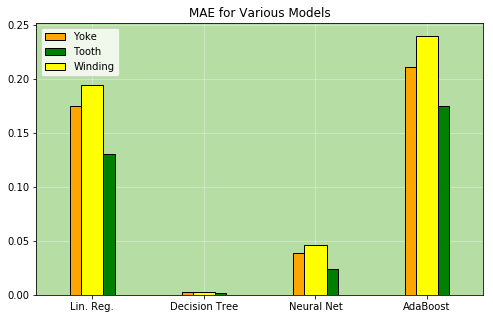

In [112]:
fig, ax = plt.subplots(figsize=(8, 5))
set_theme()

ax.bar(metrics.index[:], metrics.iloc[:, 1].values, color='orange', 
       edgecolor='k', linewidth=1, width=-0.2, align='edge', 
       alpha=1)

ax.bar(metrics.index[:], metrics.iloc[:, 0].values, color='green', 
       edgecolor='k', linewidth=1, width=0.2, align='edge', 
       alpha=1)

ax.bar(metrics.index[:], metrics.iloc[:, 2].values, color='yellow', 
       edgecolor='k', linewidth=1, width=.2, alpha=1)

plt.xlim(-.5, 3.5)
plt.legend(['Yoke', 'Tooth', 'Winding'])
plt.title('MAE for Various Models')
plt.show()

### 5.5 Extra Tree Regressor

5.5.1 Instantiating the model

In [113]:
ext_yoke = ExtraTreeRegressor()
ext_tooth = ExtraTreeRegressor()
ext_winding = ExtraTreeRegressor()

5.5.2 Fitting a basic model

In [114]:
start_timer = time()
ext_yoke.fit(X_train, yoke_train)
ext_tooth.fit(X_train, tooth_train)
ext_winding.fit(X_train, winding_train)
stop_timer = time()
print(str(int(stop_timer-start_timer)), 'seconds')

0 seconds


5.5.3 Making predictions

In [115]:
ext_yoke_pred = ext_yoke.predict(X_test)
ext_tooth_pred = ext_tooth.predict(X_test)
ext_winding_pred = ext_winding.predict(X_test)

5.5.4 Evaluating predictions

In [116]:
mae_ext_yoke = mean_absolute_error(yoke_test, ext_yoke_pred)
mae_ext_tooth = mean_absolute_error(tooth_test, ext_tooth_pred)
mae_ext_winding = mean_absolute_error(winding_test, ext_winding_pred)
mae_ext_yoke, mae_ext_tooth, mae_ext_winding

(0.002083347747695101, 0.0033293946791861507, 0.003664773641035985)

5.5.5 Grid search

In [117]:
yoke_grid = RandomizedSearchCV(ext_yoke, cv=3,
            param_distributions=
                        {'max_depth': np.linspace(3, 100, 25, dtype=int),
                         'min_samples_leaf': np.linspace(1, 100, 50, dtype=int)},
                         n_jobs=-1, n_iter=1_00)
tooth_grid = RandomizedSearchCV(ext_tooth, cv=5,
            param_distributions=
                        {'max_depth': np.linspace(3, 100, 25, dtype=int),
                         'min_samples_leaf': np.linspace(1, 100, 50, dtype=int)},
                         n_jobs=-1, n_iter=1_00)
winding_grid = RandomizedSearchCV(ext_winding, cv=5,
            param_distributions=
                        {'max_depth': np.linspace(3, 100, 25, dtype=int),
                         'min_samples_leaf': np.linspace(1, 100, 50, dtype=int)},
                         n_jobs=-1, n_iter=1_00)

In [118]:
start_timer = time()
yoke_grid.fit(X_train, yoke_train)
tooth_grid.fit(X_train, tooth_train)
winding_grid.fit(X_train, winding_train)
stop_timer = time()
print(str(int(stop_timer-start_timer)), 'seconds')

21 seconds


In [119]:
ext_yoke_pred_cv = yoke_grid.best_estimator_.predict(X_test)
ext_tooth_pred_cv = tooth_grid.best_estimator_.predict(X_test)
ext_winding_pred_cv = winding_grid.best_estimator_.predict(X_test)

In [120]:
ext_yoke_pred_cv_mae = mean_absolute_error(yoke_test, ext_yoke_pred_cv)
ext_tooth_pred_cv_mae = mean_absolute_error(tooth_test, ext_tooth_pred_cv)
ext_winding_pred_cv_mae = mean_absolute_error(winding_test, ext_winding_pred_cv)
ext_yoke_pred_cv_mae, ext_tooth_pred_cv_mae, ext_winding_pred_cv_mae

(0.00364949673226968, 0.0025155882278224254, 0.014629122864923584)

5.5.6 Interpreting coefficients

In [121]:
pd.DataFrame([tree_yoke.feature_importances_, tree_tooth.feature_importances_, 
              tree_winding.feature_importances_], index=['Yoke', 'Tooth', 'Winding'], 
              columns=df.drop(['yoke', 'tooth', 'winding'], 
             axis=1).columns.values)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm
Yoke,0.000409,0.669342,0.016652,0.007577,0.003491,0.006325,0.019702,0.006661,0.269841
Tooth,0.000270,0.011678,0.037183,0.019931,0.015219,0.087017,0.001411,0.095883,0.731410
Winding,0.017744,0.000438,0.125032,0.012457,0.007002,0.048073,0.054685,0.024685,0.709884


5.5.7 Making a metrics dataframe

In [122]:
metrics_ext = pd.DataFrame([mae_ext_yoke, mae_ext_tooth, 
                            mae_ext_winding], columns=['Extra Trees'], 
                            index=['MAE Yoke', 'MAE Tooth', 'MAE Winding']).T

metrics = pd.concat([metrics, metrics_ext], axis=0, sort=False)
metrics

,MAE Yoke,MAE Tooth,MAE Winding
Lin. Reg.,0.130515,0.174454,0.194115
Decision Tree,0.001676,0.002238,0.002940
Neural Net,0.024188,0.038797,0.046081
AdaBoost,0.174567,0.210693,0.239822
Extra Trees,0.002083,0.003329,0.003665


5.5.8 Plotting the metrics

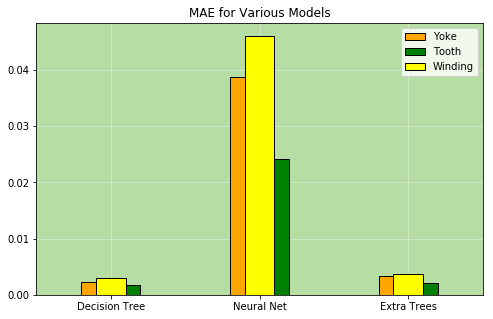

In [126]:
fig, ax = plt.subplots(figsize=(8, 5))
set_theme()

ax.bar(metrics.index[[1, 2, 4]], metrics.iloc[[1, 2, 4], 1].values, color='orange', 
       edgecolor='k', linewidth=1, width=-0.2, align='edge', 
       alpha=1)

ax.bar(metrics.index[[1, 2, 4]], metrics.iloc[[1, 2, 4], 0].values, color='green', 
       edgecolor='k', linewidth=1, width=0.2, align='edge', 
       alpha=1)

ax.bar(metrics.index[[1, 2, 4]], metrics.iloc[[1, 2, 4], 2].values, color='yellow', 
       edgecolor='k', linewidth=1, width=.2, alpha=1)

plt.xlim(-.5, 2.5)
plt.legend(['Yoke', 'Tooth', 'Winding'])
plt.title('MAE for Various Models')
plt.show()

### 5.6 Random Forest Regressor

5.6.1 Instantiating the model

In [127]:
rf_yoke = RandomForestRegressor(n_estimators=100, min_samples_leaf=10)
rf_tooth = RandomForestRegressor(n_estimators=100, min_samples_leaf=10)
rf_winding = RandomForestRegressor(n_estimators=100, min_samples_leaf=10)

5.6.2 Fitting a basic model

In [128]:
start_timer = time()
rf_yoke.fit(X_train, yoke_train)
rf_tooth.fit(X_train, tooth_train)
rf_winding.fit(X_train, winding_train)
stop_timer = time()
print(str(int(stop_timer-start_timer)), 'seconds')
alert()

71 seconds


5.6.3 Making predictions

In [129]:
rf_yoke_pred = rf_yoke.predict(X_test)
rf_tooth_pred = rf_tooth.predict(X_test)
rf_winding_pred = rf_winding.predict(X_test)

5.5.4 Evaluating predictions

In [130]:
mae_rf_yoke = mean_absolute_error(yoke_test, rf_yoke_pred)
mae_rf_tooth = mean_absolute_error(tooth_test, rf_tooth_pred)
mae_rf_winding = mean_absolute_error(winding_test, rf_winding_pred)
mae_rf_yoke, mae_rf_tooth, mae_rf_winding

(0.0026076813916418484, 0.00370135569189068, 0.004498487374014646)

5.5.5 Interpreting coefficients

In [131]:
pd.DataFrame([tree_yoke.feature_importances_, tree_tooth.feature_importances_, 
              tree_winding.feature_importances_], index=['Yoke', 'Tooth', 'Winding'], 
              columns=df.drop(['yoke', 'tooth', 'winding'], 
             axis=1).columns.values)

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm
Yoke,0.000409,0.669342,0.016652,0.007577,0.003491,0.006325,0.019702,0.006661,0.269841
Tooth,0.000270,0.011678,0.037183,0.019931,0.015219,0.087017,0.001411,0.095883,0.731410
Winding,0.017744,0.000438,0.125032,0.012457,0.007002,0.048073,0.054685,0.024685,0.709884


5.5.6 Making a metrics dataframe

In [132]:
metrics_rf = pd.DataFrame([mae_rf_yoke, mae_rf_tooth, 
                            mae_rf_winding], columns=['Random Forest'], 
                            index=['MAE Yoke', 'MAE Tooth', 'MAE Winding']).T

metrics = pd.concat([metrics, metrics_rf], axis=0, sort=False)
metrics

,MAE Yoke,MAE Tooth,MAE Winding
Lin. Reg.,0.130515,0.174454,0.194115
Decision Tree,0.001676,0.002238,0.002940
Neural Net,0.024188,0.038797,0.046081
AdaBoost,0.174567,0.210693,0.239822
Extra Trees,0.002083,0.003329,0.003665
Random Forest,0.002608,0.003701,0.004498


5.5.7 Plotting the metrics

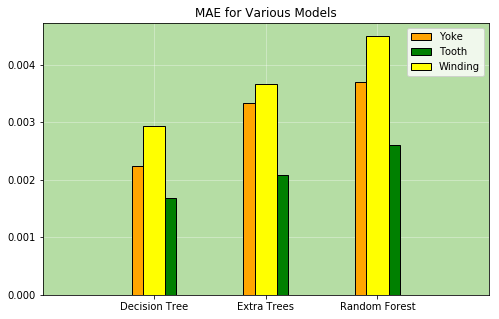

In [133]:
fig, ax = plt.subplots(figsize=(8, 5))
set_theme()

ax.bar(metrics.index[[1, 4, 5]], metrics.iloc[[1, 4, 5], 1].values, color='orange', 
       edgecolor='k', linewidth=1, width=-0.2, align='edge', 
       alpha=1)

ax.bar(metrics.index[[1, 4, 5]], metrics.iloc[[1, 4, 5], 0].values, color='green', 
       edgecolor='k', linewidth=1, width=0.2, align='edge', 
       alpha=1)

ax.bar(metrics.index[[1, 4, 5]], metrics.iloc[[1, 4, 5], 2].values, color='yellow', 
       edgecolor='k', linewidth=1, width=.2, alpha=1)

plt.xlim(-1, 3)
plt.legend(['Yoke', 'Tooth', 'Winding'])
plt.title('MAE for Various Models')
plt.show()

### 5.7 Multi-Layer Perceptron Regressor

5.7.1 Instantiating the model

In [134]:
mlp_yoke = MLPRegressor(hidden_layer_sizes=(48, 96, 128), batch_size=128, 
                        verbose=True, alpha=.0001, early_stopping=True,
                        validation_fraction=1e-1) 
mlp_tooth = MLPRegressor(hidden_layer_sizes=(48, 96, 128), batch_size=128, 
                         verbose=True, alpha=.0001, early_stopping=True,
                        validation_fraction=1e-1)
mlp_winding = MLPRegressor(hidden_layer_sizes=(48, 96, 128), batch_size=128, 
                           verbose=True, alpha=.0001, early_stopping=True,
                        validation_fraction=1e-1)

5.6.2 Fitting a basic model

In [135]:
start_timer = time()
mlp_yoke.fit(X_train, yoke_train)
mlp_tooth.fit(X_train, tooth_train)
mlp_winding.fit(X_train, winding_train)
stop_timer = time()
print(str(int(stop_timer-start_timer)), 'seconds')
alert()

Iteration 1, loss = 0.02788637
Validation score: 0.989422
Iteration 2, loss = 0.00325410
Validation score: 0.995491
Iteration 3, loss = 0.00164304
Validation score: 0.997401
Iteration 4, loss = 0.00121233
Validation score: 0.998181
Iteration 5, loss = 0.00099881
Validation score: 0.998299
Iteration 6, loss = 0.00092035
Validation score: 0.998149
Iteration 7, loss = 0.00092285
Validation score: 0.998765
Iteration 8, loss = 0.00078745
Validation score: 0.998677
Iteration 9, loss = 0.00082725
Validation score: 0.998812
Iteration 10, loss = 0.00078450
Validation score: 0.998515
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 0.03498186
Validation score: 0.980151
Iteration 2, loss = 0.00904154
Validation score: 0.986689
Iteration 3, loss = 0.00477112
Validation score: 0.993473
Iteration 4, loss = 0.00333813
Validation score: 0.995573
Iteration 5, loss = 0.00265785
Validation score: 0.995891
Iteration 6, loss = 0.00239119
Vali

5.6.3 Making predictions

In [136]:
mlp_yoke_pred = mlp_yoke.predict(X_test)
mlp_tooth_pred = mlp_tooth.predict(X_test)
mlp_winding_pred = mlp_winding.predict(X_test)

5.5.4 Evaluating predictions

In [137]:
mae_mlp_yoke = mean_absolute_error(yoke_test, mlp_yoke_pred)
mae_mlp_tooth = mean_absolute_error(tooth_test, mlp_tooth_pred)
mae_mlp_winding = mean_absolute_error(winding_test, mlp_winding_pred)
mae_mlp_yoke, mae_mlp_tooth, mae_mlp_winding

(0.019477105943019008, 0.027979039865052912, 0.02367108535582188)

5.5.6 Making a metrics dataframe

In [138]:
metrics_mlp = pd.DataFrame([mae_mlp_yoke, mae_mlp_tooth, 
                            mae_mlp_winding], columns=['Perceptron'], 
                            index=['MAE Yoke', 'MAE Tooth', 'MAE Winding']).T

metrics = pd.concat([metrics, metrics_mlp], axis=0, sort=False)
metrics

,MAE Yoke,MAE Tooth,MAE Winding
Lin. Reg.,0.130515,0.174454,0.194115
Decision Tree,0.001676,0.002238,0.002940
Neural Net,0.024188,0.038797,0.046081
AdaBoost,0.174567,0.210693,0.239822
Extra Trees,0.002083,0.003329,0.003665
Random Forest,0.002608,0.003701,0.004498
Perceptron,0.019477,0.027979,0.023671


5.5.7 Plotting the metrics

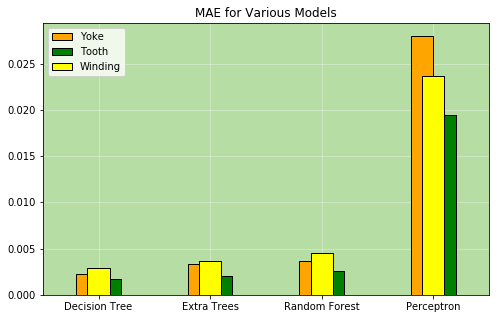

In [139]:
fig, ax = plt.subplots(figsize=(8, 5))
set_theme()

ax.bar(metrics.index[[1, 4, 5, 6]], metrics.iloc[[1, 4, 5, 6], 1].values, color='orange', 
       edgecolor='k', linewidth=1, width=-0.2, align='edge', 
       alpha=1)

ax.bar(metrics.index[[1, 4, 5, 6]], metrics.iloc[[1, 4, 5, 6], 0].values, color='green', 
       edgecolor='k', linewidth=1, width=0.2, align='edge', 
       alpha=1)

ax.bar(metrics.index[[1, 4, 5, 6]], metrics.iloc[[1, 4, 5, 6], 2].values, color='yellow', 
       edgecolor='k', linewidth=1, width=.2, alpha=1)

plt.xlim(-.5, 3.5)
plt.legend(['Yoke', 'Tooth', 'Winding'])
plt.title('MAE for Various Models')
plt.show()

### 5.8 Bagging Regressor

5.8.1 Instantiating the model

In [140]:
bag_yoke = BaggingRegressor(tree_yoke)
bag_tooth = BaggingRegressor(tree_tooth)
bag_winding = BaggingRegressor(tree_winding)

5.8.3 Fitting a basic model

In [141]:
start_timer = time()
bag_yoke.fit(X_train, yoke_train)
bag_tooth.fit(X_train, tooth_train)
bag_winding.fit(X_train, winding_train)
stop_timer = time()
print(str(int(stop_timer-start_timer)), 'seconds')

8 seconds


5.5.3 Making predictions

In [142]:
bag_yoke_pred = bag_yoke.predict(X_test)
bag_tooth_pred = bag_tooth.predict(X_test)
bag_winding_pred = bag_winding.predict(X_test)

5.5.4 Evaluating predictions

In [143]:
mae_bag_yoke = mean_absolute_error(yoke_test, bag_yoke_pred)
mae_bag_tooth = mean_absolute_error(tooth_test, bag_tooth_pred)
mae_bag_winding = mean_absolute_error(winding_test, bag_winding_pred)
mae_bag_yoke, mae_bag_tooth, mae_bag_winding

(0.001620443093577333, 0.00219417315171001, 0.0027988373772071164)

5.5.5 Grid search

In [165]:
yoke_grid = RandomizedSearchCV(bag_yoke, cv=3,
            param_distributions=
                        {'max_samples': np.linspace(.75, 1., 25),
                         'n_estimators':[7, 8, 9, 10, 11, 12, 13]},
                         n_jobs=-1, n_iter=20)
tooth_grid = RandomizedSearchCV(bag_tooth, cv=5,
            param_distributions=
                        {'max_samples': np.linspace(.75, 1., 25),
                         'n_estimators':[7, 8, 9, 10, 11, 12, 13]},
                         n_jobs=-1, n_iter=20)
winding_grid = RandomizedSearchCV(bag_winding, cv=5,
            param_distributions=
                        {'max_samples': np.linspace(.75, 1., 25),
                         'n_estimators':[7, 8, 9, 10, 11, 12, 13]},
                         n_jobs=-1, n_iter=20)

In [166]:
start_timer = time()
yoke_grid.fit(X_train, yoke_train)
tooth_grid.fit(X_train, tooth_train)
winding_grid.fit(X_train, winding_train)
stop_timer = time()
print(str(int(stop_timer-start_timer)), 'seconds')
alert()

233 seconds


In [167]:
tooth_grid.best_params_, yoke_grid.best_params_, winding_grid.best_params_

({'n_estimators': 11, 'max_samples': 0.8958333333333333},
 {'n_estimators': 12, 'max_samples': 0.8333333333333334},
 {'n_estimators': 9, 'max_samples': 0.8229166666666666})

In [168]:
bag_yoke_pred_cv = yoke_grid.best_estimator_.predict(X_test)
bag_tooth_pred_cv = tooth_grid.best_estimator_.predict(X_test)
bag_winding_pred_cv = winding_grid.best_estimator_.predict(X_test)

In [169]:
bag_yoke_pred_cv_mae = mean_absolute_error(yoke_test, bag_yoke_pred_cv)
bag_tooth_pred_cv_mae = mean_absolute_error(tooth_test, bag_tooth_pred_cv)
bag_winding_pred_cv_mae = mean_absolute_error(winding_test, bag_winding_pred_cv)
bag_yoke_pred_cv_mae, bag_tooth_pred_cv_mae, bag_winding_pred_cv_mae

(0.0015910627446702008, 0.002162611807924626, 0.003056335748541774)

5.5.7 Making a metrics dataframe

In [172]:
metrics_bag = pd.DataFrame([bag_yoke_pred_cv_mae, bag_tooth_pred_cv_mae, 
                            bag_winding_pred_cv_mae], columns=['Bagging'], 
                            index=['MAE Yoke', 'MAE Tooth', 'MAE Winding']).T

metrics = pd.concat([metrics, metrics_bag], axis=0, sort=False)
metrics

,MAE Yoke,MAE Tooth,MAE Winding
Lin. Reg.,0.130515,0.174454,0.194115
Decision Tree,0.001676,0.002238,0.002940
Neural Net,0.024188,0.038797,0.046081
AdaBoost,0.174567,0.210693,0.239822
Extra Trees,0.002083,0.003329,0.003665
Random Forest,0.002608,0.003701,0.004498
Perceptron,0.019477,0.027979,0.023671
Bagging,0.001591,0.002163,0.003056


5.5.8 Plotting the metrics

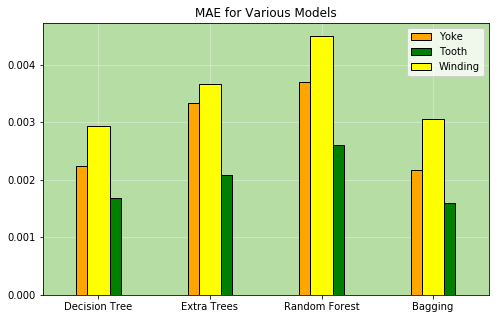

In [175]:
fig, ax = plt.subplots(figsize=(8, 5))
set_theme()

ax.bar(metrics.index[[1, 4, 5, 7]], metrics.iloc[[1, 4, 5, 7], 1].values, color='orange', 
       edgecolor='k', linewidth=1, width=-0.2, align='edge', 
       alpha=1)

ax.bar(metrics.index[[1, 4, 5, 7]], metrics.iloc[[1, 4, 5, 7], 0].values, color='green', 
       edgecolor='k', linewidth=1, width=0.2, align='edge', 
       alpha=1)

ax.bar(metrics.index[[1, 4, 5, 7]], metrics.iloc[[1, 4, 5, 7], 2].values, color='yellow', 
       edgecolor='k', linewidth=1, width=.2, alpha=1)

plt.xlim(-.5, 3.5)
plt.legend(['Yoke', 'Tooth', 'Winding'])
plt.title('MAE for Various Models')
plt.show()

## 6. Final results of selected models

In [200]:
yoke_predict = bag_yoke.predict(X_test)
tooth_predict = bag_tooth.predict(X_test)
winding_predict = tree_winding.predict(X_test)

In [241]:
random = np.random.uniform(0, 1, X_test.shape[0])

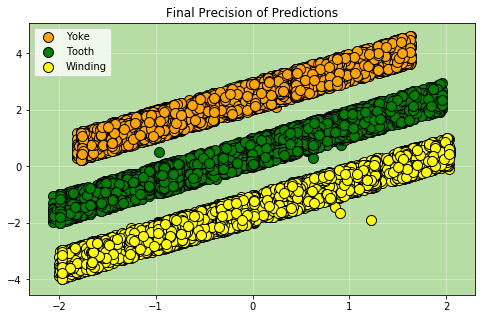

In [254]:
fig, ax = plt.subplots(figsize=(8, 5))
set_theme()

ax.scatter(yoke_test, yoke_predict+random + 2, 
           color='orange', edgecolor='k', s=100)

ax.scatter(tooth_test, tooth_predict+random, 
           color='green', edgecolor='k', s=100)

ax.scatter(winding_test, winding_predict+random - 2, 
           color='yellow', edgecolor='k', s=100)

plt.legend(['Yoke', 'Tooth', 'Winding'])
plt.title('Final Precision of Predictions')
plt.show()

I expanded the data to show how much all three make a straight line. It's nearly perfect accuracy on the test set.

In [276]:
print('Final Stator Yoke mean absolute error: %f.'%np.round(metrics.loc['Bagging', 'MAE Yoke'], 10))
print('Final Stator Tooth mean absolute error: %f.'%np.round(metrics.loc['Bagging', 'MAE Tooth'], 10))
print('Final Stator Winding mean absolute error: %f.'%np.round(metrics.loc['Decision Tree', 'MAE Winding'], 10))

Final Stator Yoke mean absolute error: 0.001591.
Final Stator Tooth mean absolute error: 0.002163.
Final Stator Winding mean absolute error: 0.002940.
